In [1]:
from concurrent.futures import ProcessPoolExecutor, _base, Future
from numpy.random import choice as np_choice
from itertools import permutations
from math import hypot, inf, sqrt
from random import randint
from typing import List
from time import time

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import heapq as hq
import acopy

# Типы и Структуры Данных. ЛР3
## Задача коммивояжёра

## Полный перебор

![](traveling_salesman_problem.png)

In [2]:
# матрицы расстояний

In [3]:
M_ = [
    [ inf, 1,   2,   7,   5   ],
    [ 1,   inf, 4,   4,   3   ],
    [ 2,   4,   inf, 1,   2   ],
    [ 7,   4,   1,   inf, 3   ],
    [ 5,   3,   2,   3,   inf ],
]

In [4]:
M_2 = [
    [ inf, 6.0, 100.0, 81.0, 23.0],
    [ 6.0, inf, 0.0, 71.0, 0.0],
    [ 100.0, 0.0, inf, 0.0, 0.0],
    [ 81.0, 71.0, 0.0, inf, 0.0],
    [ 23.0, 0.0, 0.0, 0.0, inf]
]

In [5]:
G_6 = [
    [inf,   1.0,  5.5,   52.3,  25.0,  8.8  ],
    [1.0,   inf,  2.5,   5.0,   5.0,   2.5  ],
    [5.5,   2.5,  inf,   14.3,  12.0,  33.3 ],
    [52.3,  5.0,  14.3,  inf,   5.1,   5.5  ],
    [25.0,  5.0,  12.0,  5.1,   inf,   99.9 ],
    [8.8,   2.5,  33.3,  5.5,   99.9,  inf  ],
]

In [6]:
G_6_int = [
    [inf, 1,   52,  52,  25,  8   ],
    [1,   inf, 2,   5,   5,   2   ],
    [5,   2,   inf, 14,  12,  33  ],
    [52,  5,   14,  inf, 5,   5   ],
    [25,  5,   12,  5,   inf, 99  ],
    [8,   2,   33,  5,   99,  inf ],
]

In [7]:
G_8 = [
    [inf,   1.0,  5.5,   52.3,  25.0,  8.8 ,  2.0,   2.5  ],
    [1.0,   inf,  2.5,   5.0,   5.0,   2.5 ,  2.5,   2.5  ],
    [5.5,   2.5,  inf,   14.3,  12.0,  33.3,  23.0,  32.5 ],
    [52.3,  5.0,  14.3,  inf,   5.1,   5.5 ,  2.2,   3.3  ],
    [25.0,  5.0,  12.0,  5.1,   inf,   99.9,  5.0,   22.5 ],
    [8.8,   2.5,  33.3,  5.5,   99.9,  inf ,  5.0,   12.5 ],
    [2.0,   2.5,  23.0,  2.2,   5.0,   5.0,   inf,   5.0  ],
    [2.5,   2.5,  32.5,  3.3,   22.5,  12.5,  5.0,   inf  ],
]

In [8]:
M_11 = [
    [ inf,  68.,  64.,  52.,  51.,  71.,  50.,   4.,  63.,  39., 100.],
    [ 68.,  inf,  73.,  57.,  39.,  82.,  63.,  39.,  45.,  18.,  53.],
    [ 64.,  73.,  inf,  72.,  36.,  64.,  35.,  99.,  66.,  76.,  68.],
    [ 52.,  57.,  72.,  inf,   9.,  24.,   6.,  25.,  81.,  51.,  20.],
    [ 51.,  39.,  36.,   9.,  inf,   1.,  92.,  43.,  27.,  69.,  71.],
    [ 71.,  82.,  64.,  24.,   1.,  inf,  52.,  53.,  98.,   4.,  65.],
    [ 50.,  63.,  35.,   6.,  92.,  52.,  inf,  58.,  94.,  23.,  29.],
    [  4.,  39.,  99.,  25.,  43.,  53.,  58.,  inf,  35.,  36.,  98.],
    [ 63.,  45.,  66.,  81.,  27.,  98.,  94.,  35.,  inf,  91.,  31.],
    [ 39.,  18.,  76.,  51.,  69.,   4.,  23.,  36.,  91.,  inf,  40.],
    [100.,  53.,  68.,  20.,  71.,  65.,  29.,  98.,  31.,  40.,  inf],
]

In [9]:
def create_distance_matrix(cities_number):
    matrix = np.zeros((cities_number, cities_number))
    for i in range(cities_number):
        for j in range(i + 1, cities_number):
            distance = randint(1, 100)  # from the minimum distance to the maximum
            matrix[i][j], matrix[j][i] = distance, distance 
            # ^^ for symmetry of the matrix with respect to the main axis

    np.fill_diagonal(matrix, inf)
    return matrix

In [10]:
# random_matrix = create_distance_matrix(12)
# random_matrix

In [11]:
# функция для подсчёта времени работы
def executeWithTimeOut(fnc, *args, **kwargs):
    with ProcessPoolExecutor() as p:
        try:
            f: Future = p.submit(fnc, *args, **kwargs)
            return f.result(timeout=600)
        except _base.TimeoutError:
            for pid, process in p._processes.items():
                process.terminate()
            p.shutdown()
            raise Exception('Process timed out.')

In [12]:
class AlgorithmResult:

    def __init__(self, path: List[int], cost: float, executionTime: float):
        self.path = path
        self.cost = cost
        self.executionTime = executionTime
 
    
def getCost(graph: List[List[float]], path: List[int]) -> float:

    cost = 0
    for i in range(len(path) - 1):
        cost += graph[path[i]][path[i + 1]]
    return cost



def bruteForceTSP(graph: List[List[float]]) -> List[int]:

    size = len(graph)
    minCost = inf
    bestPath = None

    for p in permutations(range(size)):
        path: List[int] = list(p)
        path.append(path[0])
        cost = getCost(graph, path)
        if minCost > cost:
            minCost = cost
            bestPath = path
    
    return bestPath


class BruteForceTSP():

    def execute(self, graph) -> AlgorithmResult:
        try:
            initialTime = time()
            path = executeWithTimeOut(bruteForceTSP, graph)
            executionTime = time() - initialTime
            cost = getCost(graph, path)
            return AlgorithmResult(path, cost, executionTime)
        except Exception as e:
            print(e)
            return AlgorithmResult([], None, None)

In [13]:
def runner_BF(matrix):
    go = BruteForceTSP()
    res = go.execute(matrix)
    print(f"Кратчайший тур: {res.path}")
    print(f"Расстояние: {res.cost}")
    print(f"Время работы перебора: {res.executionTime}")
    return res.cost

In [14]:
etalon_M_ = runner_BF(M_)

Кратчайший тур: [0, 1, 4, 3, 2, 0]
Расстояние: 10
Время работы перебора: 0.11882996559143066


In [15]:
etalon_M_2 = runner_BF(M_2)

Кратчайший тур: [0, 1, 2, 3, 4, 0]
Расстояние: 29.0
Время работы перебора: 0.0585629940032959


In [16]:
etalon_G_6 = runner_BF(G_6)

Кратчайший тур: [0, 1, 5, 3, 4, 2, 0]
Расстояние: 31.6
Время работы перебора: 0.05062365531921387


In [17]:
etalon_G_6_int = runner_BF(G_6_int)

Кратчайший тур: [0, 1, 5, 3, 4, 2, 0]
Расстояние: 30
Время работы перебора: 0.0439915657043457


In [18]:
etalon_G_8 = runner_BF(G_8)

Кратчайший тур: [0, 7, 3, 4, 6, 5, 1, 2, 0]
Расстояние: 31.4
Время работы перебора: 0.11732220649719238


In [19]:
etalon_M_11 = runner_BF(M_11)

Кратчайший тур: [0, 2, 6, 3, 10, 8, 4, 5, 9, 1, 7, 0]
Расстояние: 249.0
Время работы перебора: 91.13990116119385


## Алгоритм Дейкстры (эксперименты)

![Alt Text](dijkstra.gif)

In [20]:
def dijkstra(graph, start, goal):
    """
        Алгоритм Дейкстры, для работы с данными в формате словаря
    """
    shortest_path = {} 
    predecessor = {} 
    unseen_nodes = graph 
    infinity = inf 
    path = [] 
    for node in unseen_nodes: 
        shortest_path[node] = infinity 
    shortest_path[start] = 0 
     
    while unseen_nodes: 
        min_node = None 
        for node in unseen_nodes: 
            if min_node is None: 
                min_node = node 
            elif shortest_path[node] < shortest_path[min_node]: 
                min_node = node 
         
        for connect_node, link_cost in graph[min_node].items(): 
            if link_cost + shortest_path[min_node] < shortest_path[connect_node]: 
                shortest_path[connect_node] = link_cost + shortest_path[min_node]  
                predecessor[connect_node] = min_node 
        unseen_nodes.pop(min_node) 
     
    current_node = goal 
    while current_node != start: 
        path.insert(0,current_node) 
        current_node = predecessor[current_node] 
     
    path.insert(0,start) 
    print(f'Кратчайший путь до цели составляет {shortest_path[goal]} условных единиц меры') 
    print(f'Путь будет проходить по следующим вершинам {path}')

### кратчайший маршрут из точки N в точку M:

In [21]:
graph_6 = { 
    'A': {'B': 1.0, 'C': 5.5, 'D': 52.3, 'E': 25.0, 'F': 8.8},
    'B': {'A': 1.0, 'C': 2.5, 'D': 5.0, 'E': 5.0, 'F': 2.5},
    'C': {'A': 5.5, 'B': 2.5, 'D': 14.3, 'E': 12.0, 'F': 33.3},
    'D': {'A': 52.3, 'B': 5.0, 'C': 14.3, 'E': 5.1, 'F': 5.5},
    'E': {'A': 25.0, 'B': 5.0, 'C': 12.0, 'D': 5.1, 'F': 99.9},
    'F': {'A': 8.8, 'B': 2.5, 'C': 33.3, 'D': 5.5, 'E': 99.9},
}

dijkstra(graph_6, 'A', 'D')

Кратчайший путь до цели составляет 6.0 условных единиц меры
Путь будет проходить по следующим вершинам ['A', 'B', 'D']


In [22]:
graph_8 = {
    'A': {'B': 6, 'C': 100, 'D': 81, 'E': 23}, 
    'B': {'A': 6, 'D': 77}, 
    'C': {'A': 100}, 
    'D': {'A': 81, 'B': 77}, 
    'E': {'A': 23}, 
}

dijkstra(graph_8, 'A', 'D')

Кратчайший путь до цели составляет 81 условных единиц меры
Путь будет проходить по следующим вершинам ['A', 'D']


### перебор всех вариантов маршрутов:

In [23]:
def dijkstra_heap(G, start=0):
    """
        Алгоритм Дейкстры, реализованный,
        с помощью стандартной библиотеки heapq (очередь кучи)
        
        G - граф
        start - стартовая вершина
    """
    n = len(G)  # количество вершин
    Q = [(0, start)]  # инициализируем массив для кучи
    d = [inf for i in range(n)]  # инициализируем массив с бесконечностями
    d[start] = 0  # присваиваем 0 стартовой вершине

    while len(Q) != 0:
        (cost, u) = hq.heappop(Q)  # выбрасываем из кучи Q

        for v in range(n):
            if d[v] > d[u] + G[u][v]:  # процесс ослабления ребра
                d[v] = d[u] + G[u][v]
                hq.heappush(Q, (d[v], v))  # добавляем в кучу Q
                
    return d

In [24]:
for i in range(len(G_6)):
    print(dijkstra_heap(G_6, i))

[0, 1.0, 3.5, 6.0, 6.0, 3.5]
[1.0, 0, 2.5, 5.0, 5.0, 2.5]
[3.5, 2.5, 0, 7.5, 7.5, 5.0]
[6.0, 5.0, 7.5, 0, 5.1, 5.5]
[6.0, 5.0, 7.5, 5.1, 0, 7.5]
[3.5, 2.5, 5.0, 5.5, 7.5, 0]


In [25]:
for i in range(len(G_8)):
    print(dijkstra_heap(G_8, i))

[0, 1.0, 3.5, 4.2, 6.0, 3.5, 2.0, 2.5]
[1.0, 0, 2.5, 4.7, 5.0, 2.5, 2.5, 2.5]
[3.5, 2.5, 0, 7.2, 7.5, 5.0, 5.0, 5.0]
[4.2, 4.7, 7.2, 0, 5.1, 5.5, 2.2, 3.3]
[6.0, 5.0, 7.5, 5.1, 0, 7.5, 5.0, 7.5]
[3.5, 2.5, 5.0, 5.5, 7.5, 0, 5.0, 5.0]
[2.0, 2.5, 5.0, 2.2, 5.0, 5.0, 0, 4.5]
[2.5, 2.5, 5.0, 3.3, 7.5, 5.0, 4.5, 0]


## Муравьиный Алгоритм

![Alt Text](ants.gif)

1. Выбираем количество муравьев N.

2. Инициализируем матрицу отложений феромонов, она такой же формы, как и матрица расстояний. И координаты соответствуют одним и тем же городам. Если distances[2,5] = 35, т.е. расстояние от 2 до 5 составляет 35, и если pheromone[2,5] = 0.8, т.е. уровень феромона, отложенного на пути между 2 и 5, составляет 0,8. Матрица феромонов инициализируется небольшими переменными одного и того же значения.

3. Изучение нескольких путей:

    Муравей принимает решение, в какой город поехать, используя следующую конструкцию:
    city_to_city_score = pheromone ** alpha * (1.0 / distance) ** beta
    альфа и бета действуют как вес на феромон и расстояние соответственно.

    Мы производим расчет city_to_city_score для всех доступных городов (мы игнорируем города, которые мы уже посетили, потому что мы не можем вернуться к ним).

    Вероятность поехать в следующий город:
    prob_of_going_to_city(i) = city_to_city_score(i) / sum_of_all_available_city_to_city_scores

    Например, если муравей находится в городе 2, а доступные города - 4,7,8. Мы рассчитываем оценки для этих городов как:
    {4: 0.2, 7: 0.4, 8: 0.8}

    Вероятность перехода на 4
    0.2 / (0.2 + 0.4 + 0.8) = 0.142857
    и так далее.

    Муравей продолжает переходить из города в город в соответствии с указанным выше правилом выбора, пока не посетит все города.

    Если мы выберем для начала 20 муравьев, у нас будет 20 путей в конце этой группы муравьёв, путешествующих поколения.

    Поскольку на начальном этапе уровни феромонов одинаковы, выбор делается на расстоянии + некоторый шум. Случайный жадный, если хотите. Но мы хотим отслеживать успешные маршруты, поэтому муравьи откладывают феромон.

4. На обратном пути все муравьи или определенное количество лучших муравьев откладывают феромоны на своих тропах.

    Они вносят:

    1 / (distance between two cities)

    Например: муравей прошел путь: [(0 -> 3) (расстояние: 8), (3 -> 5) (расстояние: 2)]

    0,125 единицы феромона откладываются на 
    pheromone[0,3] += 0.125
    и
    pheromone[3,5] += 0.5

    Это сделано для того, чтобы муравьи стали уделять больше внимания более коротким маршрутам между городами.

5. И последнее: мы должны позволить феромонам распадаться(выветриваться, испаряться), чтобы старые феромоны не сбивали с толку следующие поколения муравьев. Мы просто умножаем матрицу феромонов на скорость распада. Сразу после внесения депозита. Следовательно, феромон, который некоторое время находился в сидячем состоянии, подвергался множеству многих распадов и должен быть небольшим.

6. Продолжаем выполнять шаги 3) 4) и 5) в кол-ве N итераций.

In [26]:
class AntColony(object):

    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Аргументы:
            distances (2D numpy.array): Квадратная матрица расстояний, главную диагональ задаём бесконечностями.
            n_ants (int): Количество муравьев, бегущих за итерацию.
            n_best (int): Количество лучших муравьев, откладывающих феромон. (вместо Q)
            n_iteration (int): Количество итераций.
            decay (float): Коэффициент распада (испарения феромона). Значение феромона умножается на к-нт распада, поэтому 0,95 приведет к распаду, 0,5 - к гораздо более быстрому распаду.
            alpha (int or float): Влияние феромона (стадность), более высокий альфа дает феромон больший вес. По умолчанию = 1
            beta (int or float): Влияние длины пути (жадность алгоритма), чем выше бета, тем больше вес расстоянию. По умолчанию = 1
        Пример:
            ant_colony = AntColony(matrix_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
        """
        self.distances = distances
        self.len_d = len(distances)
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.Q = (self.len_d * self.len_d - self.len_d) / self.len_d  # !!

    # запуск колонии
    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path            
            self.pheromone * self.decay            
        return all_time_shortest_path

    # распространение феромона
    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += self.Q / self.distances[move]
                

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start))  # возвращаемся туда, где мы начали
        return path

    # выбор следующего города муравья
    def pick_move(self, pheromone, dist, visited):
#         print(self.Q)
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0
        
        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)
        norm_row = row / row.sum()
        
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move

Метод np_choice работает в качестве "подброшенной монетки" для выбора хода следующим образом: move = np_choice(self.all_inds, 1, p=norm_row)[0] Мы передаём методу три параметра:

all_inds (длина матрицы расстояний, для матрицы 5х5 - будет значение 5)
число 1 - длина возвращаемого массива (т.е. возвращаемое значение метода - это массив с кол-вом элементов (в нашем случае 1), каждый в интервале от 0 до 5)
p=norm_row (параметр p принимает 1-мерный массив, это вероятности, связанные с all_inds)
norm_row рассчитываем по формуле: norm_row = row / row.sum()

А row рассчитываем по ф-ле: row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta) где: pheromone - матрица (одномерный массив) феромона (numpy массив вида [0. 0.2 0.2 0.2 0.2]), где нулями заполнены значения по индексам уже посещённых городов; self.alpha - влияние феромона, в моих экспериментах - 1; dist - матрица (одномерный массив) вида [inf inf 83. 90. inf], с предыдущим ходом; self.beta - влияние длины пути, в моих экспериментах - 1;

Таким образом, для примера, передав в np_choice следующие параметры: (5, 1, p=[0., 0., 0.52023121, 0.47976879, 0.]) -- на выходе получаем массив с одним элементом: [2] -- выбранный ход муравья.

In [27]:
def runner_ant_algo(matrix, ro, a, tmax):
    distances = np.array(matrix)
    ant_colony = AntColony(
        distances=distances,  # матрица расстояний
        n_ants=len(matrix),   # количество муравьёв
        n_best=len(matrix),   # количество муравьёв с феромоном
        n_iterations=tmax,    # количество итераций (tmax)
        decay=ro,             # количество испарения феромона (ро)
        alpha=a,              # влияние феромона
        beta=1                # влияние длины пути
    )

    shortest_path = ant_colony.run()
    print(f"Оптимальный маршрут: {shortest_path[0]}")
    print(f"Расстояние маршрута: {shortest_path[1]}")
    print(f"Время жизни колонии: {tmax} суток")
    print(f"Испарение феромона (ро): {ro}")
    print(f"Влияние феромона (альфа): {a}")
    return shortest_path[1]

In [28]:
parameters = {
    "ro_a": [0.001, 0.25, 0.5, 0.75, 1],
    "iters": [20, 50, 100, 150, 200],
}

In [29]:
def all_params_runner(matrix, params=parameters, iters=3):
    res = [[], [], []]
    for iter in range(1, iters + 1):
        print(f"Итерация №{iter}\n")
        prms = [[i for i in params[x]] for x in params.keys()]
        for _ in range(len(prms[0])):
            res[iter-1].append(runner_ant_algo(matrix=matrix, ro=prms[0][_], a=prms[0][_], tmax=prms[1][_]))
            print()
        print(f"{88 * '#'}")
    return res

### матрица M_

In [30]:
res_M_ = all_params_runner(M_)

Итерация №1

Оптимальный маршрут: [(0, 2), (2, 3), (3, 4), (4, 1), (1, 0)]
Расстояние маршрута: 10.0
Время жизни колонии: 20 суток
Испарение феромона (ро): 0.001
Влияние феромона (альфа): 0.001

Оптимальный маршрут: [(0, 2), (2, 3), (3, 4), (4, 1), (1, 0)]
Расстояние маршрута: 10.0
Время жизни колонии: 50 суток
Испарение феромона (ро): 0.25
Влияние феромона (альфа): 0.25

Оптимальный маршрут: [(0, 2), (2, 3), (3, 4), (4, 1), (1, 0)]
Расстояние маршрута: 10.0
Время жизни колонии: 100 суток
Испарение феромона (ро): 0.5
Влияние феромона (альфа): 0.5

Оптимальный маршрут: [(0, 1), (1, 4), (4, 3), (3, 2), (2, 0)]
Расстояние маршрута: 10.0
Время жизни колонии: 150 суток
Испарение феромона (ро): 0.75
Влияние феромона (альфа): 0.75

Оптимальный маршрут: [(0, 2), (2, 3), (3, 4), (4, 1), (1, 0)]
Расстояние маршрута: 10.0
Время жизни колонии: 200 суток
Испарение феромона (ро): 1
Влияние феромона (альфа): 1

########################################################################################
И

In [31]:
res_M_

[[10.0, 10.0, 10.0, 10.0, 10.0],
 [10.0, 10.0, 10.0, 10.0, 10.0],
 [10.0, 10.0, 10.0, 10.0, 10.0]]

### матрица G_6_int

In [32]:
res_G_6_int = all_params_runner(G_6_int)

Итерация №1

Оптимальный маршрут: [(0, 1), (1, 5), (5, 3), (3, 4), (4, 2), (2, 0)]
Расстояние маршрута: 30.0
Время жизни колонии: 20 суток
Испарение феромона (ро): 0.001
Влияние феромона (альфа): 0.001

Оптимальный маршрут: [(0, 1), (1, 5), (5, 3), (3, 4), (4, 2), (2, 0)]
Расстояние маршрута: 30.0
Время жизни колонии: 50 суток
Испарение феромона (ро): 0.25
Влияние феромона (альфа): 0.25

Оптимальный маршрут: [(0, 1), (1, 5), (5, 3), (3, 4), (4, 2), (2, 0)]
Расстояние маршрута: 30.0
Время жизни колонии: 100 суток
Испарение феромона (ро): 0.5
Влияние феромона (альфа): 0.5

Оптимальный маршрут: [(0, 1), (1, 5), (5, 3), (3, 4), (4, 2), (2, 0)]
Расстояние маршрута: 30.0
Время жизни колонии: 150 суток
Испарение феромона (ро): 0.75
Влияние феромона (альфа): 0.75

Оптимальный маршрут: [(0, 1), (1, 5), (5, 3), (3, 4), (4, 2), (2, 0)]
Расстояние маршрута: 30.0
Время жизни колонии: 200 суток
Испарение феромона (ро): 1
Влияние феромона (альфа): 1

##################################################

In [33]:
res_G_6_int

[[30.0, 30.0, 30.0, 30.0, 30.0],
 [30.0, 30.0, 30.0, 30.0, 30.0],
 [30.0, 30.0, 30.0, 30.0, 30.0]]

### матрица G_6

In [34]:
res_G_6 = all_params_runner(G_6)

Итерация №1

Оптимальный маршрут: [(0, 1), (1, 5), (5, 3), (3, 4), (4, 2), (2, 0)]
Расстояние маршрута: 31.6
Время жизни колонии: 20 суток
Испарение феромона (ро): 0.001
Влияние феромона (альфа): 0.001

Оптимальный маршрут: [(0, 1), (1, 5), (5, 3), (3, 4), (4, 2), (2, 0)]
Расстояние маршрута: 31.6
Время жизни колонии: 50 суток
Испарение феромона (ро): 0.25
Влияние феромона (альфа): 0.25

Оптимальный маршрут: [(0, 1), (1, 5), (5, 3), (3, 4), (4, 2), (2, 0)]
Расстояние маршрута: 31.6
Время жизни колонии: 100 суток
Испарение феромона (ро): 0.5
Влияние феромона (альфа): 0.5

Оптимальный маршрут: [(0, 1), (1, 5), (5, 3), (3, 4), (4, 2), (2, 0)]
Расстояние маршрута: 31.6
Время жизни колонии: 150 суток
Испарение феромона (ро): 0.75
Влияние феромона (альфа): 0.75

Оптимальный маршрут: [(0, 1), (1, 5), (5, 3), (3, 4), (4, 2), (2, 0)]
Расстояние маршрута: 31.6
Время жизни колонии: 200 суток
Испарение феромона (ро): 1
Влияние феромона (альфа): 1

##################################################

In [35]:
res_G_6

[[31.6, 31.6, 31.6, 31.6, 31.6],
 [31.6, 31.6, 31.6, 31.6, 34.900000000000006],
 [31.6, 31.6, 31.6, 31.6, 31.6]]

### матрица G_8

In [36]:
res_G_8 = all_params_runner(G_8)

Итерация №1

Оптимальный маршрут: [(0, 7), (7, 3), (3, 4), (4, 6), (6, 5), (5, 1), (1, 2), (2, 0)]
Расстояние маршрута: 31.4
Время жизни колонии: 20 суток
Испарение феромона (ро): 0.001
Влияние феромона (альфа): 0.001

Оптимальный маршрут: [(0, 7), (7, 3), (3, 4), (4, 6), (6, 5), (5, 1), (1, 2), (2, 0)]
Расстояние маршрута: 31.4
Время жизни колонии: 50 суток
Испарение феромона (ро): 0.25
Влияние феромона (альфа): 0.25

Оптимальный маршрут: [(0, 6), (6, 5), (5, 1), (1, 2), (2, 4), (4, 3), (3, 7), (7, 0)]
Расстояние маршрута: 34.9
Время жизни колонии: 100 суток
Испарение феромона (ро): 0.5
Влияние феромона (альфа): 0.5

Оптимальный маршрут: [(0, 1), (1, 2), (2, 4), (4, 6), (6, 5), (5, 3), (3, 7), (7, 0)]
Расстояние маршрута: 36.8
Время жизни колонии: 150 суток
Испарение феромона (ро): 0.75
Влияние феромона (альфа): 0.75

Оптимальный маршрут: [(0, 6), (6, 4), (4, 2), (2, 1), (1, 5), (5, 3), (3, 7), (7, 0)]
Расстояние маршрута: 35.3
Время жизни колонии: 200 суток
Испарение феромона (ро): 1

In [37]:
res_G_8

[[31.4, 31.4, 34.9, 36.8, 35.3],
 [35.3, 34.9, 31.4, 36.8, 38.4],
 [33.6, 33.6, 35.3, 34.9, 33.6]]

In [38]:
final_res_G_8 = []

for _ in range(len(res_G_8[0])):
    final_res_G_8.append(min(res_G_8[0][_], res_G_8[1][_], res_G_8[2][_]))
    
final_res_G_8

[31.4, 31.4, 31.4, 34.9, 33.6]

### матрица M_11

In [39]:
res_M_11 = all_params_runner(M_11)

Итерация №1

Оптимальный маршрут: [(0, 7), (7, 1), (1, 9), (9, 5), (5, 4), (4, 3), (3, 6), (6, 10), (10, 8), (8, 2), (2, 0)]
Расстояние маршрута: 271.0
Время жизни колонии: 20 суток
Испарение феромона (ро): 0.001
Влияние феромона (альфа): 0.001

Оптимальный маршрут: [(0, 7), (7, 1), (1, 9), (9, 5), (5, 4), (4, 8), (8, 10), (10, 3), (3, 6), (6, 2), (2, 0)]
Расстояние маршрута: 249.0
Время жизни колонии: 50 суток
Испарение феромона (ро): 0.25
Влияние феромона (альфа): 0.25

Оптимальный маршрут: [(0, 7), (7, 1), (1, 9), (9, 5), (5, 4), (4, 8), (8, 10), (10, 3), (3, 6), (6, 2), (2, 0)]
Расстояние маршрута: 249.0
Время жизни колонии: 100 суток
Испарение феромона (ро): 0.5
Влияние феромона (альфа): 0.5

Оптимальный маршрут: [(0, 7), (7, 1), (1, 9), (9, 5), (5, 4), (4, 8), (8, 10), (10, 3), (3, 6), (6, 2), (2, 0)]
Расстояние маршрута: 249.0
Время жизни колонии: 150 суток
Испарение феромона (ро): 0.75
Влияние феромона (альфа): 0.75

Оптимальный маршрут: [(0, 7), (7, 1), (1, 9), (9, 5), (5, 4),

In [40]:
res_M_11

[[271.0, 249.0, 249.0, 249.0, 249.0],
 [274.0, 249.0, 249.0, 249.0, 249.0],
 [267.0, 257.0, 249.0, 257.0, 260.0]]

In [41]:
final_res_M_11 = []

for _ in range(len(res_G_8[0])):
    final_res_M_11.append(min(res_M_11[0][_], res_M_11[1][_], res_M_11[2][_]))
    
final_res_M_11

[267.0, 249.0, 249.0, 249.0, 249.0]

### Cводная таблица по Муравьиному Алгоритму

In [42]:
best_minus_etalon_G_8 = []

for i in range(len(final_res_G_8)):
    best_minus_etalon_G_8.append(final_res_G_8[i] - etalon_G_8)
    
best_minus_etalon_G_8

[0.0, 0.0, 0.0, 3.5, 2.200000000000003]

In [43]:
best_minus_etalon_M_11 = []

for i in range(len(final_res_M_11)):
    best_minus_etalon_M_11.append(final_res_M_11[i] - etalon_M_11)
    
best_minus_etalon_M_11

[18.0, 0.0, 0.0, 0.0, 0.0]

In [44]:
datka = {
    'Alpha': parameters['ro_a'],
    'Ro/Tau': parameters['ro_a'],
    'tmax': parameters['iters'],
    'G_8 L_best': final_res_G_8,
    'G_8 L_best - L_etalon': best_minus_etalon_G_8,
    'M_11 L_best': final_res_M_11,
    'M_11 L_best - L_etalon': best_minus_etalon_M_11,
}

df = pd.DataFrame(
    datka,
    index=[np.arange(1, 6)],
)

df

,Alpha,Ro/Tau,tmax,G_8 L_best,G_8 L_best - L_etalon,M_11 L_best,M_11 L_best - L_etalon
1,0.001,0.001,20,31.4,0.0,267.0,18.0
2,0.250,0.250,50,31.4,0.0,249.0,0.0
3,0.500,0.500,100,31.4,0.0,249.0,0.0
4,0.750,0.750,150,34.9,3.5,249.0,0.0
5,1.000,1.000,200,33.6,2.2,249.0,0.0


## Эксперименты с [ACOpy](https://acopy.readthedocs.io/)

In [46]:
solver = acopy.Solver(rho=1.0, q=4)
colony = acopy.Colony(alpha=.5, beta=.5)

stats = acopy.plugins.StatsRecorder()
solver.add_plugin(stats)

timer = acopy.plugins.Timer()
solver.add_plugin(timer)

printout = acopy.plugins.Printout()
solver.add_plugin(printout)

# darwin = acopy.plugins.Darwin(sigma=.25)
# elite = acopy.plugins.EliteTracer(factor=2)
# periodic = acopy.plugins.PeriodicActionPlugin(period=100)
# PeriodicReset
# PheromoneFlip
# EarlyTerminationPlugin
# threshold = acopy.plugins.Threshold(threshold=1719)
# time_limit = acopy.plugins.TimeLimit(seconds=30)

### граф G_6

In [47]:
G6 = nx.from_numpy_matrix(np.array(G_6))

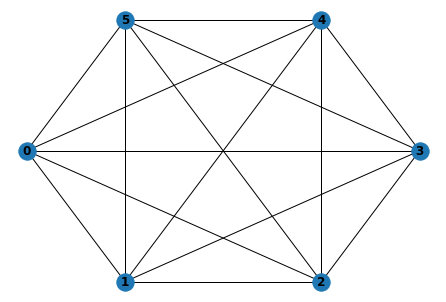

In [48]:
nx.draw_shell(G6, with_labels=True, font_weight='bold')

In [49]:
tour = solver.solve(G6, colony, limit=100)

Using 6 ants from Colony(alpha=0.5, beta=0.5)
Performing 100 iterations:
Iteration  Cost                 Solution
1          128.3                0 1 5 4 3 2
2          46.599999999999994   0 1 4 2 3 5
5          34.9                 0 1 2 4 3 5
38         31.6                 0 2 4 3 5 1
-------------------------------------------


In [50]:
display(tour.cost, tour.nodes, tour.path)

31.6

[3, 5, 1, 0, 2, 4]

[(3, 5), (5, 1), (1, 0), (0, 2), (2, 4), (4, 3)]

### графики

In [51]:
# stats.data

In [52]:
# stats.stats.keys()
# stats.stats.get('pheromone_levels')

In [53]:
aplot = acopy.utils.plot.Plotter(stats.stats)

In [54]:
aplot.extract_ant_distances()

[]

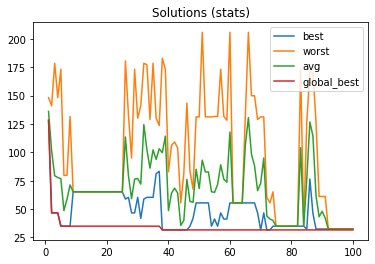

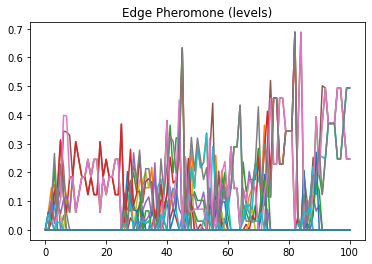

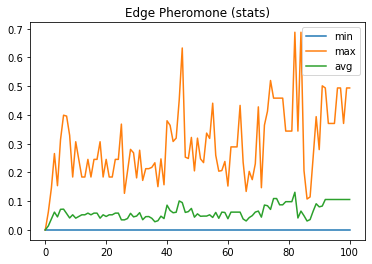

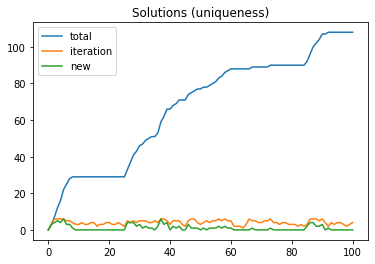

In [55]:
aplot.plot()

### граф M_

In [56]:
G_M = nx.from_numpy_matrix(np.array(M_))

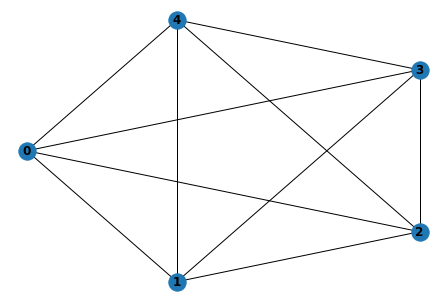

In [57]:
nx.draw_shell(G_M, with_labels=True, font_weight='bold')

In [58]:
tour = solver.solve(G_M, colony, limit=100)

Using 5 ants from Colony(alpha=0.5, beta=0.5)
Performing 100 iterations:
Iteration  Cost                 Solution
1          10.0                 0 1 4 3 2
-----------------------------------------


In [59]:
display(tour.cost, tour.nodes, tour.path)

10.0

[1, 4, 3, 2, 0]

[(1, 4), (4, 3), (3, 2), (2, 0), (0, 1)]

### граф G_6_int

In [60]:
G6_int = nx.from_numpy_matrix(np.array(G_6_int))

In [61]:
tour = solver.solve(G6_int, colony, limit=100)

Using 6 ants from Colony(alpha=0.5, beta=0.5)
Performing 100 iterations:
Iteration  Cost                 Solution
1          126.0                0 1 5 4 3 2
2          39.0                 0 5 1 4 3 2
6          37.0                 0 5 1 3 4 2
15         30.0                 0 5 3 4 1 2
-------------------------------------------


In [62]:
display(tour.cost, tour.nodes, tour.path)

30.0

[3, 4, 1, 2, 0, 5]

[(3, 4), (4, 1), (1, 2), (2, 0), (0, 5), (5, 3)]

### граф G_8

In [63]:
G8 = nx.from_numpy_matrix(np.array(G_8))

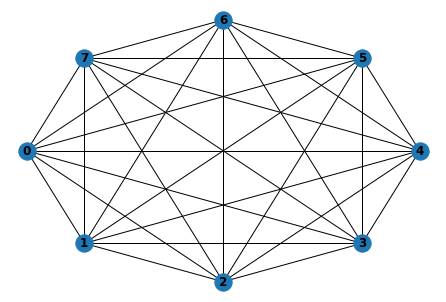

In [64]:
nx.draw_shell(G8, with_labels=True, font_weight='bold')

In [65]:
tour = solver.solve(G8, colony, limit=100)

Using 8 ants from Colony(alpha=0.5, beta=0.5)
Performing 100 iterations:
Iteration  Cost                 Solution
1          54.2                 0 5 7 6 4 3 2 1
2          51.900000000000006   0 5 6 4 2 3 7 1
4          47.3                 0 5 7 3 6 4 2 1
11         43.4                 0 6 5 7 3 4 2 1
13         42.8                 0 7 5 6 3 4 2 1
14         40.6                 0 7 1 2 4 3 6 5
22         35.3                 0 7 3 5 1 2 4 6
23         34.9                 0 7 3 4 2 1 5 6
79         31.400000000000002   0 2 1 5 6 4 3 7
-----------------------------------------------


In [66]:
display(tour.cost, tour.nodes, tour.path)

31.400000000000002

[1, 5, 6, 4, 3, 7, 0, 2]

[(1, 5), (5, 6), (6, 4), (4, 3), (3, 7), (7, 0), (0, 2), (2, 1)]

### M_11

In [68]:
GM11 = nx.from_numpy_matrix(np.array(M_11))

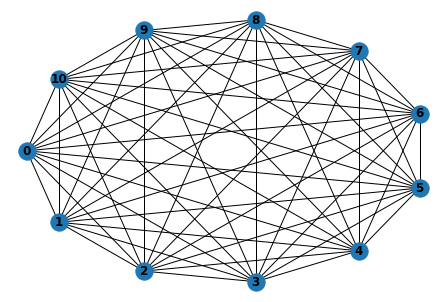

In [69]:
nx.draw_shell(GM11, with_labels=True, font_weight='bold')

In [70]:
tour = solver.solve(GM11, colony, limit=1000)

Using 11 ants from Colony(alpha=0.5, beta=0.5)
Performing 1000 iterations:
Iteration  Cost                 Solution
1          478.0                 0  9 10  8  7  6  5  4  3  2  1
2          415.0                 0  7  9  6  5  4  3  2  8 10  1
3          351.0                 0  4  2  6  3  5 10  8  1  9  7
7          338.0                 0  2 10  5  4  3  6  9  1  8  7
8          303.0                 0  2  6  3 10  4  5  9  1  8  7
9          271.0                 0  2  6  3 10  8  1  9  5  4  7
72         264.0                 0  2  6 10  3  4  5  9  1  8  7
81         260.0                 0  2  6  3  4  5  9  1 10  8  7
85         257.0                 0  7  1  9  5  4  2  6  3 10  8
100        249.0                 0  7  1  9  5  4  8 10  3  6  2


----------------------------------------------------------------


In [71]:
display(tour.cost, tour.nodes, tour.path)

249.0

[0, 7, 1, 9, 5, 4, 8, 10, 3, 6, 2]

[(0, 7),
 (7, 1),
 (1, 9),
 (9, 5),
 (5, 4),
 (4, 8),
 (8, 10),
 (10, 3),
 (3, 6),
 (6, 2),
 (2, 0)]